In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
trainDir1 = r"/home/trojan/Desktop/dimentia/data_10slices/dataset with PGGAN/train"
trainDir2 = r"/home/trojan/Desktop/dimentia/data_10slices/edge_data/train"
input_shape1 = Input(shape=(256, 256, 3))
input_shape2 = Input(shape=(256, 256, 1))
dropout_rate = 0.2
batch_size = 16
height, width = 256, 256

In [3]:
def lr_schedule(epoch):
    lr = 1e-3 #1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 20: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)

def generate_generator_multiple(generator, dir1, dir2, batch_size, img_height, img_width, subset):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (img_height, img_width),
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset=subset
                                         )
                                          

    genX2 = generator.flow_from_directory(dir2,
                                          target_size = (img_height, img_width),
                                          color_mode='grayscale',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset=subset
                                         )
    
    while True:
        X1i = genX1.next()
        X2i = genX2.next()

        yield [X1i[0], X2i[0]], X2i[1]
    
    
train_generator = generate_generator_multiple(generator=train_datagen,
                                              dir1=trainDir1,
                                              dir2=trainDir2,
                                              batch_size=batch_size,
                                              img_height=height,
                                              img_width=width,
                                              subset='training'
                                             )

                    
valid_generator = generate_generator_multiple(generator=train_datagen,
                                              dir1=trainDir1,
                                              dir2=trainDir2,
                                              batch_size=batch_size,
                                              img_height=height,
                                              img_width=width,
                                              subset='validation'
                                             )

In [5]:
input_shape = concatenate([input_shape1, input_shape2], axis=-1)
cnn_top = Conv2D(32, (5,5), padding='same', activation='relu')(input_shape)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(512, (3,3), padding='same', activation='relu',)(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Flatten()(cnn_top)
cnn_top = Dense(256)(cnn_top)
cnn_top = Dropout(dropout_rate)(cnn_top)
cnn_top = Dense(128)(cnn_top)
cnn_top = Dropout(dropout_rate)(cnn_top)
output = Dense(2)(cnn_top)

In [6]:
model = Model([input_shape1, input_shape2], output)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
                       
model.summary()

Learning rate:  0.001
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 4)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 3232        

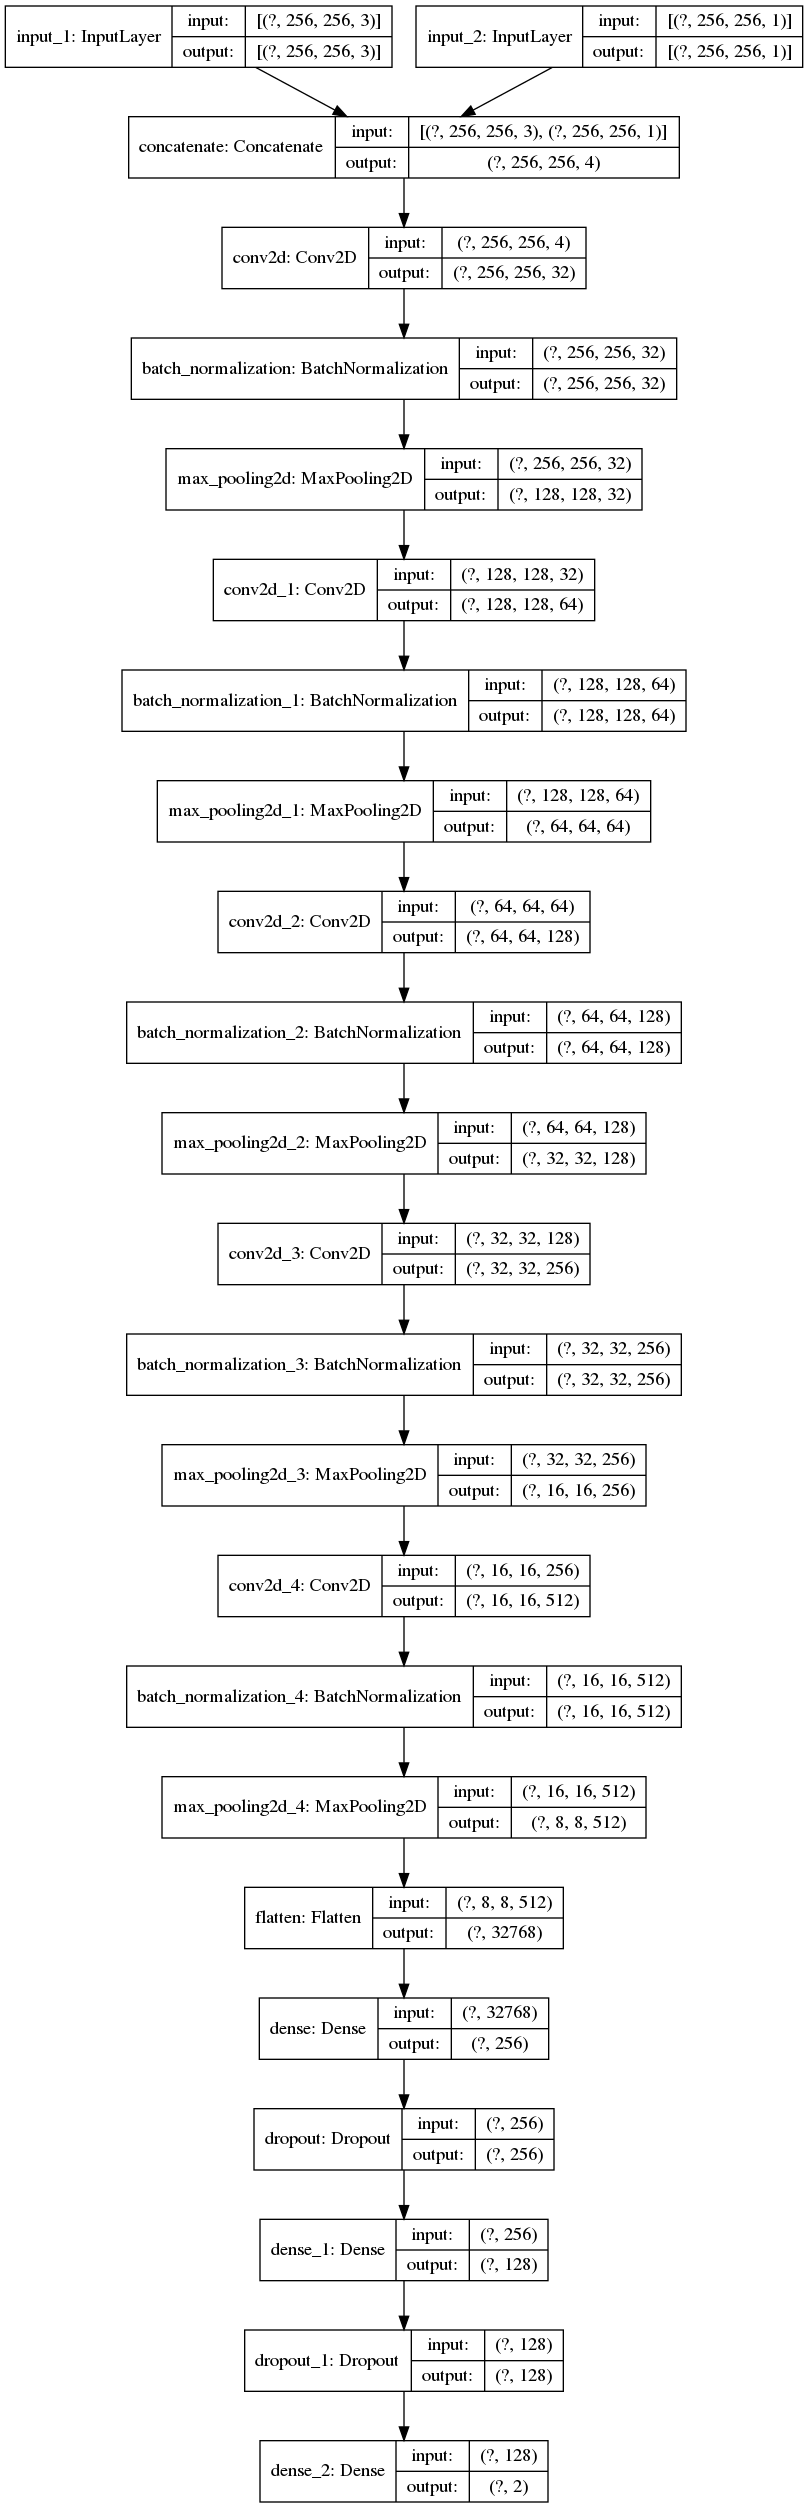

In [7]:
tf.keras.utils.plot_model(model, to_file='my_model.png', show_shapes=True)

In [8]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [9]:
import math

DATA_SIZE = 19677
TRAINING_SIZE = DATA_SIZE*0.8 
VALIDATION_SIZE = DATA_SIZE*0.2

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

STEP_SIZE_TRAIN = compute_steps_per_epoch(TRAINING_SIZE)
STEP_SIZE_VALID = compute_steps_per_epoch(VALIDATION_SIZE)

In [ ]:
#final_train_generator = zip(train_generator, train_generator, train_generator)
#final_test_generator  = zip(test_generator, test_generator, test_generator)
model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=3,
                          validation_data=valid_generator, verbose=1, workers=1, 
                          validation_steps=STEP_SIZE_VALID, callbacks=checkpoint,
                          shuffle=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Found 15743 images belonging to 2 classes.
Found 15743 images belonging to 2 classes.
Epoch 1/3
120/984 [==>...........................] - ETA: 5:21 - loss: 0.0144 - categorical_accuracy: 0.9969

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [ ]:
score = model.evaluate_generator(generator=valid_generator, verbose=1,
steps=STEP_SIZE_VALID)

print("Loss: ", score[0], "Accuracy: ", score[1])